In [ ]:
import RAE
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from itertools import product
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

import plotly.express as px
from pyproj import Transformer

import os
import joblib

import importlib
import json
import itertools

In [ ]:
def visualize_trajectories(df, color_by='MMSI', title=None, zoom=5, height=800):
    
    transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(df['UTM_x'].values, df['UTM_y'].values)
    
    if 'Trajectory' in df.columns:
        vis_cols = ['Trajectory', 'MMSI', 'Timestamp', 'UTM_x', 'UTM_y']
    else:
        vis_cols = ['MMSI', 'Timestamp', 'UTM_x', 'UTM_y']

    if color_by not in vis_cols:
        vis_cols.append(color_by)

    if 'SOG' in df.columns and 'SOG' not in vis_cols:
        vis_cols.append('SOG')
    
    vis_df = df[vis_cols].copy()
    vis_df['Longitude'] = lon
    vis_df['Latitude'] = lat
    
    # Generate title if not provided
    if title is None:
        date_min = vis_df['Timestamp'].min().date()
        date_max = vis_df['Timestamp'].max().date()
        title = f"Ship Trajectories - {date_min} to {date_max}"
    
    # Create visualization with trajectories using lat/lon on a map
    fig = px.line_map(
        vis_df.sort_values('Timestamp'),
        lat="Latitude",
        lon="Longitude",
        color=color_by,
        hover_data=["MMSI", "Timestamp", "SOG"] if "SOG" in vis_df.columns else ["MMSI", "Timestamp"],
        zoom=zoom,
        title=title
    )
    
    fig.update_layout(
        mapbox_style="open-street-map",
        showlegend=False,  # Hide legend since there can be many trajectories
        height=height
    )
    
    print(f"✓ Visualization complete - colored by '{color_by}'")
    
    return fig

In [ ]:
train = pd.read_parquet('../../data/aisdk/train/aisdk_2025')
val = pd.read_parquet('../../data/aisdk/val/aisdk_2025')

In [ ]:
obj = joblib.load(os.path.join("..", "..", "data", "aisdk", "scaler", "scaler_aisdk_2025.pkl"))

saved_feature_names = None

if isinstance(obj, StandardScaler):
    scaler = obj
    # If you stored feature names separately, keep as None here
    print("Loaded StandardScaler object from joblib.")
elif isinstance(obj, dict):
    scaler = StandardScaler()
    scaler.mean_ = np.asarray(obj['mean'])
    scaler.scale_ = np.asarray(obj['scale'])
    saved_feature_names = obj.get('feature_names', None)
    print("Reconstructed StandardScaler from dict params.")
else:
    raise TypeError(f"Unexpected scaler payload type: {type(obj)}")

print("Scaler ready. n_features:", scaler.mean_.shape[0],
      "| feature names:", (list(saved_feature_names) if saved_feature_names is not None else "None"))

In [ ]:
# Un-scale train and val DataFrames for visualization
def inverse_scale_df(df, scaler, cols, saved_feature_names=None):
    cols = [c for c in cols if c in df.columns]
    if not cols:
        return df.copy(), []
    Xs = df[cols].to_numpy()
    mean = np.asarray(scaler.mean_)
    scale = np.asarray(scaler.scale_)
    # Align mean/scale to column order if saved feature names exist
    if saved_feature_names is not None:
        name_to_idx = {name: i for i, name in enumerate(saved_feature_names)}
        idx = []
        for c in cols:
            if c in name_to_idx:
                idx.append(name_to_idx[c])
            else:
                # Fallback: assume same order for missing names
                idx.append(cols.index(c))
        mean_aligned = mean[idx]
        scale_aligned = scale[idx]
    else:
        # Assume the first N features correspond to the selected columns
        mean_aligned = mean[:len(cols)]
        scale_aligned = scale[:len(cols)]
    X = Xs * scale_aligned + mean_aligned
    out = df.copy()
    out.loc[:, cols] = X
    return out, cols

# Choose columns that were scaled during preprocessing
candidate_cols = ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']

train_vis, train_cols = inverse_scale_df(train, scaler, candidate_cols, saved_feature_names)
val_vis, val_cols = inverse_scale_df(val, scaler, candidate_cols, saved_feature_names)
print(f"Train unscaled columns: {train_cols}")
print(f"Val unscaled columns: {val_cols}")

In [ ]:
fig = visualize_trajectories(val_vis, color_by='Trajectory')
fig.show()

In [ ]:
# Turn train and val sets into lists of trajectories
train_trajectories = []
    
for traj_id in train['Trajectory'].unique():
    traj_data = train[train['Trajectory'] == traj_id].sort_values('Timestamp')
    features = traj_data[['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']].values
    train_trajectories.append(features)

print(f"Total trajectories: {len(train_trajectories)}")

In [ ]:
val_trajectories = []
    
for traj_id in val['Trajectory'].unique():
    traj_data = val[val['Trajectory'] == traj_id].sort_values('Timestamp')
    features = traj_data[['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']].values
    val_trajectories.append(features)

print(f"Total trajectories: {len(val_trajectories)}")

In [ ]:
class TrajectoryDataset(Dataset):
    def __init__(self, trajectories):
        self.trajectories = trajectories
    
    def __len__(self):
        return len(self.trajectories)
    
    def __getitem__(self, idx):
        traj = torch.FloatTensor(self.trajectories[idx])
        return traj

In [ ]:
def pad_trajectories(batch):
    lengths = torch.tensor([len(traj) for traj in batch])
    padded = pad_sequence(batch, batch_first=True, padding_value=0.0)

    lengths, perm_idx = lengths.sort(descending=True)
    padded = padded[perm_idx]

    return padded, lengths

In [ ]:
train_dataset = TrajectoryDataset(train_trajectories)
val_dataset = TrajectoryDataset(val_trajectories)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
importlib.reload(RAE)

In [ ]:
# model, train_losses, val_losses = RAE.train_RAE(
#     train_dataset,
#     val_dataset,
#     device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
#     feature_size=5,
#     encoder_layers=3,
#     decoder_layers=2,
#     latent_dim=12,  
#     hidden_size=64,
#     learning_rate=0.001,
#     batch_size=256,
#     max_epochs=50,
#     teacher_forcing_ratio=0.9,
#     dropout=0.1,
#     patience=10
# )

In [ ]:
def hyperparameter_search(
    train_dataset,
    val_dataset,
    device,
    feature_size,
    search_type='grid',
    save_dir='../../checkpoints/rae'
):
    import os
    import itertools
    import numpy as np
    os.makedirs(save_dir, exist_ok=True)
    
    print("="*70)
    print("HYPERPARAMETER TUNING FOR RAE")
    print("="*70)
    
    # Define search space - FOCUSED on most impactful parameters
    if search_type == 'grid':
        param_grid = {
            # High impact - tune these
            'latent_dim': [8, 12, 16],
            'teacher_forcing_ratio': [0.3, 0.5, 0.7],
            'dropout': [0.1, 0.2],
            'learning_rate': [0.0005, 0.001],
            
            # Fixed - don't tune (saves time)
            'encoder_layers': [3],
            'decoder_layers': [2],
            'hidden_size': [64],
            'batch_size': [256],
            'max_epochs': [25],
            'patience': [8],
            'min_delta': [0.0001]
        }
        # Total: 3 * 3 * 2 * 2 = 36 combinations (~2-3 hours)
        
    elif search_type == 'random':
        param_grid = {
            'latent_dim': [8, 10, 12, 14, 16],
            'teacher_forcing_ratio': [0.3, 0.4, 0.5, 0.6, 0.7],
            'dropout': [0.1, 0.15, 0.2, 0.25, 0.3],
            'learning_rate': [0.0003, 0.0005, 0.001, 0.002],
            'hidden_size': [48, 64, 80],
            
            # Fixed
            'encoder_layers': [3],
            'decoder_layers': [2],
            'batch_size': [256],
            'max_epochs': [25],
            'patience': [8],
            'min_delta': [0.0001]
        }
        
    elif search_type == 'quick':
        # Even faster - just test key variations
        param_grid = {
            'latent_dim': [10, 12],
            'teacher_forcing_ratio': [0.5, 0.7],
            'dropout': [0.1, 0.2],
            'learning_rate': [0.001],
            
            # Fixed
            'encoder_layers': [3],
            'decoder_layers': [2],
            'hidden_size': [64],
            'batch_size': [256],
            'max_epochs': [25],
            'patience': [8],
            'min_delta': [0.0001]
        }
        # Total: 2 * 2 * 2 = 8 combinations (~30-40 min)
    
    # Generate parameter combinations
    if search_type in ['grid', 'quick']:
        keys = param_grid.keys()
        values = param_grid.values()
        combinations = list(itertools.product(*values))
        param_combinations = [dict(zip(keys, combo)) for combo in combinations]
        print(f"Grid Search: {len(param_combinations)} combinations")
        
    elif search_type == 'random':
        n_random = 20
        param_combinations = []
        for _ in range(n_random):
            params = {k: np.random.choice(v) for k, v in param_grid.items()}
            param_combinations.append(params)
        print(f"Random Search: {n_random} combinations")
    
    print(f"Estimated time: {len(param_combinations) * 5} minutes")
    print("="*70)
    
    # Track results
    results = []
    best_score = float('inf')
    best_params = None
    
    start_time = datetime.now()
    
    for idx, params in enumerate(param_combinations):
        print(f"\n{'='*70}")
        print(f"Trial {idx+1}/{len(param_combinations)}")
        print(f"Time elapsed: {(datetime.now() - start_time).total_seconds()/60:.1f} min")
        print(f"{'='*70}")
        print(f"Testing: latent_dim={params['latent_dim']}, "
              f"TF={params['teacher_forcing_ratio']}, "
              f"dropout={params['dropout']}, "
              f"lr={params['learning_rate']}")
        
        try:
            # Train model using your existing function
            model, train_losses, val_losses = RAE.train_RAE(
                train_dataset=train_dataset,
                val_dataset=val_dataset,
                device=device,
                feature_size=feature_size,
                **params  # All params match train_RAE signature now
            )
            
            # Extract metrics from training
            best_val_loss = min(val_losses)
            best_epoch = val_losses.index(best_val_loss) + 1
            final_train_loss = train_losses[best_epoch - 1]
            overfit_ratio = best_val_loss / max(final_train_loss, 1e-6)
            
            # Compute latent space quality
            from torch.utils.data import DataLoader
            
            val_loader = DataLoader(
                val_dataset,
                batch_size=params['batch_size'],
                shuffle=False,
                collate_fn=pad_trajectories
            )
            
            model.eval()
            all_latents = []
            with torch.no_grad():
                for batch_data, lengths in val_loader:
                    batch_data = batch_data.to(device)
                    lengths = lengths.to(device)
                    _, z = model(batch_data, lengths, teacher_forcing_ratio=0.0)
                    all_latents.append(z.cpu())
            
            all_latents = torch.cat(all_latents, dim=0).numpy()
            latent_std = all_latents.std()
            var_per_dim = all_latents.var(axis=0)
            active_dims = (var_per_dim > 0.01).sum()
            
            # Composite score (lower is better)
            score = (
                best_val_loss * 1.0 +                          # Primary metric
                max(0, 0.4 - latent_std) * 0.3 +              # Penalty if std < 0.4
                (params['latent_dim'] - active_dims) * 0.05 +  # Penalty for inactive dims
                max(0, overfit_ratio - 2.0) * 0.2             # Penalty if overfitting > 2x
            )
            
            result = {
                **params,
                'best_val_loss': float(best_val_loss),
                'best_epoch': int(best_epoch),
                'final_train_loss': float(final_train_loss),
                'overfit_ratio': float(overfit_ratio),
                'latent_std': float(latent_std),
                'active_dims': int(active_dims),
                'mean_var_per_dim': float(var_per_dim.mean()),
                'composite_score': float(score),
                'trial': idx + 1
            }
            
            results.append(result)
            
            print(f"\nResults:")
            print(f"  Val Loss: {best_val_loss:.4f}")
            print(f"  Latent Std: {latent_std:.4f}")
            print(f"  Active Dims: {active_dims}/{params['latent_dim']}")
            print(f"  Overfit Ratio: {overfit_ratio:.2f}")
            print(f"  Composite Score: {score:.4f}")
            
            if score < best_score:
                best_score = score
                best_params = params.copy()
                print(f"  ⭐ NEW BEST!")
                
                # Save best model
                torch.save(model.state_dict(), f"{save_dir}/best_model.pth")
            
            # Clean up
            del model
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"  ❌ FAILED: {str(e)}")
            import traceback
            traceback.print_exc()
            result = {**params, 'error': str(e), 'trial': idx + 1}
            results.append(result)
    
    # Save results
    if len(results) == 0:
        print("\n❌ No trials completed!")
        return None, None
        
    df = pd.DataFrame(results)
    
    # Only sort by composite_score if there are successful trials
    if 'composite_score' in df.columns:
        df = df.sort_values('composite_score', na_position='last')
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = f"{save_dir}/results_{timestamp}.csv"
    df.to_csv(csv_path, index=False)
    
    if best_params is None:
        print("\n❌ All trials failed! Check error messages above.")
        return df, None
    
    json_path = f"{save_dir}/best_params_{timestamp}.json"
    with open(json_path, 'w') as f:
        json.dump(best_params, f, indent=2)
    
    # Print summary
    total_time = (datetime.now() - start_time).total_seconds() / 60
    print(f"\n{'='*70}")
    print(f"HYPERPARAMETER SEARCH COMPLETE")
    print(f"{'='*70}")
    print(f"Total time: {total_time:.1f} minutes")
    
    successful = [r for r in results if 'error' not in r]
    print(f"Successful trials: {len(successful)}/{len(results)}")
    
    if len(successful) == 0:
        print("\n❌ No successful trials!")
        return df, None
    
    print(f"\nBest parameters (score={best_score:.4f}):")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print(f"\nResults saved to: {csv_path}")
    print(f"Best params saved to: {json_path}")
    print(f"Best model saved to: {save_dir}/best_model.pth")
    
    # Show top 5 (only successful trials)
    print(f"\nTop 5 configurations:")
    successful_df = df[df['composite_score'].notna()]
    top_cols = ['latent_dim', 'teacher_forcing_ratio', 'dropout', 'learning_rate', 
                'best_val_loss', 'latent_std', 'composite_score']
    print(successful_df[top_cols].head())
    
    return df, best_params

In [ ]:
# Quick test (8 combinations, ~30-40 min)
df, best_params = hyperparameter_search(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    feature_size=5,  # your feature size
    search_type='quick'
)

In [19]:
# Full grid search (36 combinations, ~2-3 hours)
df, best_params = hyperparameter_search(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    feature_size=5,
    search_type='grid'
)

HYPERPARAMETER TUNING FOR RAE
Grid Search: 36 combinations
Estimated time: 180 minutes

Trial 1/36
Time elapsed: 0.0 min
Testing: latent_dim=8, TF=0.3, dropout=0.1, lr=0.0005
Training RAE: latent_dim=8, hidden=64, enc_layers=3, dec_layers=2
Model parameters: 217,373

DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0113
  Std (overall): 0.6688 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.605, std=0.441, var=0.1942 ✓
  Dim 1: mean=+0.016, std=0.647, var=0.4191 ✓
  Dim 2: mean=+0.129, std=0.638, var=0.4066 ✓
  Dim 3: mean=-0.026, std=0.745, var=0.5554 ✓
  Dim 4: mean=+0.028, std=0.720, var=0.5178 ✓
  Dim 5: mean=+0.294, std=0.546, var=0.2986 ✓
  Dim 6: mean=+0.167, std=0.606, var=0.3678 ✓
  Dim 7: mean=+0.089, std=0.560, var=0.3137 ✓

Epoch 1/25 [TF=0.3] - Train: 4.9065, Val: 5.1384 ✓
Epoch 2/25 [TF=0.3] - Train: 4.6232, Val: 5.1026 ✓
Epoch 3/25 [TF=0.3] - Train: 4.1437, Val: 4.9972 ✓
Epoch 4/25 [TF=0.3] - T

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0083
  Std (overall): 0.6582 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.342, std=0.500, var=0.2501 ✓
  Dim 1: mean=-0.044, std=0.786, var=0.6172 ✓
  Dim 2: mean=+0.005, std=0.649, var=0.4211 ✓
  Dim 3: mean=+0.345, std=0.511, var=0.2607 ✓
  Dim 4: mean=-0.052, std=0.698, var=0.4876 ✓
  Dim 5: mean=+0.005, std=0.520, var=0.2706 ✓
  Dim 6: mean=+0.095, std=0.721, var=0.5198 ✓
  Dim 7: mean=+0.054, std=0.622, var=0.3863 ✓

Epoch 1/25 [TF=0.3] - Train: 4.8531, Val: 5.1227 ✓
Epoch 2/25 [TF=0.3] - Train: 4.1824, Val: 5.0693 ✓
Epoch 3/25 [TF=0.3] - Train: 2.8529, Val: 5.3740 (patience: 1/8)
Epoch 4/25 [TF=0.3] - Train: 1.7043, Val: 4.4878 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): 0.0061
  Std (overall): 0.6775 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.048, std=0.653, var=

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0177
  Std (overall): 0.6647 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.023, std=0.637, var=0.4054 ✓
  Dim 1: mean=-0.176, std=0.811, var=0.6583 ✓
  Dim 2: mean=-0.080, std=0.715, var=0.5113 ✓
  Dim 3: mean=+0.003, std=0.591, var=0.3490 ✓
  Dim 4: mean=+0.181, std=0.649, var=0.4216 ✓
  Dim 5: mean=+0.193, std=0.485, var=0.2356 ✓
  Dim 6: mean=-0.038, std=0.568, var=0.3224 ✓
  Dim 7: mean=+0.034, std=0.723, var=0.5228 ✓

Epoch 1/25 [TF=0.3] - Train: 4.9330, Val: 5.1416 ✓
Epoch 2/25 [TF=0.3] - Train: 4.6258, Val: 5.1108 ✓
Epoch 3/25 [TF=0.3] - Train: 4.2260, Val: 5.0706 ✓
Epoch 4/25 [TF=0.3] - Train: 3.6094, Val: 4.6434 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): 0.0113
  Std (overall): 0.6834 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.078, std=0.769, var=0.5916 ✓
  Dim

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0051
  Std (overall): 0.6625 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.038, std=0.499, var=0.2494 ✓
  Dim 1: mean=+0.239, std=0.659, var=0.4340 ✓
  Dim 2: mean=+0.089, std=0.645, var=0.4162 ✓
  Dim 3: mean=+0.073, std=0.535, var=0.2859 ✓
  Dim 4: mean=-0.163, std=0.707, var=0.5004 ✓
  Dim 5: mean=-0.265, std=0.555, var=0.3085 ✓
  Dim 6: mean=-0.019, std=0.716, var=0.5132 ✓
  Dim 7: mean=-0.033, std=0.796, var=0.6338 ✓

Epoch 1/25 [TF=0.3] - Train: 4.6699, Val: 5.0976 ✓
Epoch 2/25 [TF=0.3] - Train: 3.6487, Val: 5.6635 (patience: 1/8)
Epoch 3/25 [TF=0.3] - Train: 2.8949, Val: 4.2057 ✓
Epoch 4/25 [TF=0.3] - Train: 1.9059, Val: 5.9536 (patience: 1/8)

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): -0.0040
  Std (overall): 0.6770 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.004,

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0023
  Std (overall): 0.6565 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.031, std=0.690, var=0.4764 ✓
  Dim 1: mean=-0.027, std=0.627, var=0.3927 ✓
  Dim 2: mean=+0.035, std=0.546, var=0.2983 ✓
  Dim 3: mean=-0.013, std=0.661, var=0.4366 ✓
  Dim 4: mean=+0.158, std=0.522, var=0.2728 ✓
  Dim 5: mean=-0.174, std=0.660, var=0.4361 ✓
  Dim 6: mean=-0.169, std=0.648, var=0.4202 ✓
  Dim 7: mean=+0.202, std=0.766, var=0.5869 ✓

Epoch 1/25 [TF=0.5] - Train: 4.9151, Val: 5.1672 ✓
Epoch 2/25 [TF=0.5] - Train: 4.4825, Val: 5.1211 ✓
Epoch 3/25 [TF=0.5] - Train: 3.9260, Val: 5.0429 ✓
Epoch 4/25 [TF=0.5] - Train: 3.2310, Val: 5.4006 (patience: 1/8)

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): -0.0007
  Std (overall): 0.6812 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.053, std=0.694, va

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0093
  Std (overall): 0.6605 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.030, std=0.603, var=0.3637 ✓
  Dim 1: mean=-0.142, std=0.663, var=0.4394 ✓
  Dim 2: mean=-0.028, std=0.717, var=0.5135 ✓
  Dim 3: mean=-0.031, std=0.656, var=0.4299 ✓
  Dim 4: mean=+0.002, std=0.573, var=0.3288 ✓
  Dim 5: mean=+0.025, std=0.701, var=0.4909 ✓
  Dim 6: mean=+0.185, std=0.540, var=0.2916 ✓
  Dim 7: mean=+0.094, std=0.753, var=0.5668 ✓

Epoch 1/25 [TF=0.5] - Train: 4.6366, Val: 5.1075 ✓
Epoch 2/25 [TF=0.5] - Train: 3.4921, Val: 4.4866 ✓
Epoch 3/25 [TF=0.5] - Train: 2.1729, Val: 5.8160 (patience: 1/8)
Epoch 4/25 [TF=0.5] - Train: 1.2241, Val: 5.0250 (patience: 2/8)

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): 0.0026
  Std (overall): 0.6712 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.076, s

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0010
  Std (overall): 0.6759 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.063, std=0.700, var=0.4897 ✓
  Dim 1: mean=+0.035, std=0.623, var=0.3883 ✓
  Dim 2: mean=+0.027, std=0.752, var=0.5649 ✓
  Dim 3: mean=-0.196, std=0.602, var=0.3627 ✓
  Dim 4: mean=+0.252, std=0.680, var=0.4626 ✓
  Dim 5: mean=+0.174, std=0.596, var=0.3557 ✓
  Dim 6: mean=-0.078, std=0.651, var=0.4243 ✓
  Dim 7: mean=-0.159, std=0.661, var=0.4373 ✓

Epoch 1/25 [TF=0.5] - Train: 4.8931, Val: 5.1777 ✓
Epoch 2/25 [TF=0.5] - Train: 4.4389, Val: 5.1187 ✓
Epoch 3/25 [TF=0.5] - Train: 3.8757, Val: 5.0649 ✓
Epoch 4/25 [TF=0.5] - Train: 3.0558, Val: 5.4246 (patience: 1/8)

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): 0.0043
  Std (overall): 0.6875 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.029, std=0.721, var

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0060
  Std (overall): 0.6635 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.079, std=0.780, var=0.6088 ✓
  Dim 1: mean=-0.004, std=0.745, var=0.5556 ✓
  Dim 2: mean=-0.164, std=0.675, var=0.4562 ✓
  Dim 3: mean=-0.175, std=0.607, var=0.3684 ✓
  Dim 4: mean=+0.060, std=0.611, var=0.3739 ✓
  Dim 5: mean=+0.002, std=0.707, var=0.4996 ✓
  Dim 6: mean=+0.161, std=0.597, var=0.3560 ✓
  Dim 7: mean=-0.008, std=0.459, var=0.2106 ✓

Epoch 1/25 [TF=0.5] - Train: 4.6378, Val: 5.1046 ✓
Epoch 2/25 [TF=0.5] - Train: 3.5317, Val: 4.7661 ✓
Epoch 3/25 [TF=0.5] - Train: 2.0854, Val: 5.2778 (patience: 1/8)
Epoch 4/25 [TF=0.5] - Train: 1.4109, Val: 6.1309 (patience: 2/8)

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): -0.0044
  Std (overall): 0.6857 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.068,

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0099
  Std (overall): 0.6691 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.016, std=0.781, var=0.6092 ✓
  Dim 1: mean=-0.073, std=0.748, var=0.5594 ✓
  Dim 2: mean=-0.137, std=0.594, var=0.3532 ✓
  Dim 3: mean=-0.048, std=0.571, var=0.3262 ✓
  Dim 4: mean=+0.071, std=0.689, var=0.4748 ✓
  Dim 5: mean=+0.390, std=0.505, var=0.2552 ✓
  Dim 6: mean=-0.020, std=0.638, var=0.4065 ✓
  Dim 7: mean=-0.120, std=0.632, var=0.3994 ✓

Epoch 1/25 [TF=0.7] - Train: 4.6870, Val: 5.1373 ✓
Epoch 2/25 [TF=0.7] - Train: 4.1353, Val: 5.0967 ✓
Epoch 3/25 [TF=0.7] - Train: 3.3719, Val: 4.9505 ✓
Epoch 4/25 [TF=0.7] - Train: 2.6065, Val: 5.2498 (patience: 1/8)

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): 0.0011
  Std (overall): 0.6708 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.130, std=0.697, var=

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0051
  Std (overall): 0.6696 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.013, std=0.715, var=0.5106 ✓
  Dim 1: mean=-0.002, std=0.652, var=0.4248 ✓
  Dim 2: mean=+0.023, std=0.689, var=0.4748 ✓
  Dim 3: mean=-0.048, std=0.567, var=0.3220 ✓
  Dim 4: mean=-0.175, std=0.548, var=0.3000 ✓
  Dim 5: mean=+0.231, std=0.670, var=0.4495 ✓
  Dim 6: mean=-0.012, std=0.640, var=0.4092 ✓
  Dim 7: mean=-0.072, std=0.777, var=0.6037 ✓

Epoch 1/25 [TF=0.7] - Train: 4.4360, Val: 5.1365 ✓
Epoch 2/25 [TF=0.7] - Train: 3.0454, Val: 4.5823 ✓
Epoch 3/25 [TF=0.7] - Train: 1.8334, Val: 7.0097 (patience: 1/8)
Epoch 4/25 [TF=0.7] - Train: 1.0190, Val: 4.7988 (patience: 2/8)

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): -0.0138
  Std (overall): 0.6898 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.103,

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0148
  Std (overall): 0.6526 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.082, std=0.698, var=0.4866 ✓
  Dim 1: mean=-0.575, std=0.413, var=0.1705 ✓
  Dim 2: mean=+0.213, std=0.609, var=0.3711 ✓
  Dim 3: mean=+0.479, std=0.294, var=0.0866 ✓
  Dim 4: mean=-0.006, std=0.664, var=0.4406 ✓
  Dim 5: mean=-0.112, std=0.763, var=0.5815 ✓
  Dim 6: mean=+0.063, std=0.484, var=0.2346 ✓
  Dim 7: mean=-0.027, std=0.639, var=0.4083 ✓

Epoch 1/25 [TF=0.7] - Train: 4.8477, Val: 5.1569 ✓
Epoch 2/25 [TF=0.7] - Train: 4.2681, Val: 5.1276 ✓
Epoch 3/25 [TF=0.7] - Train: 3.5844, Val: 5.0950 ✓
Epoch 4/25 [TF=0.7] - Train: 2.7509, Val: 5.2756 (patience: 1/8)

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): 0.0062
  Std (overall): 0.6868 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.023, std=0.661, var=

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0041
  Std (overall): 0.6611 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.517, std=0.494, var=0.2441 ✓
  Dim 1: mean=+0.228, std=0.608, var=0.3702 ✓
  Dim 2: mean=+0.320, std=0.438, var=0.1916 ✓
  Dim 3: mean=-0.023, std=0.791, var=0.6260 ✓
  Dim 4: mean=+0.067, std=0.775, var=0.6012 ✓
  Dim 5: mean=-0.188, std=0.481, var=0.2313 ✓
  Dim 6: mean=+0.071, std=0.621, var=0.3857 ✓
  Dim 7: mean=+0.008, std=0.616, var=0.3791 ✓

Epoch 1/25 [TF=0.7] - Train: 4.6087, Val: 5.1306 ✓
Epoch 2/25 [TF=0.7] - Train: 3.3331, Val: 4.9627 ✓
Epoch 3/25 [TF=0.7] - Train: 1.9192, Val: 5.4196 (patience: 1/8)
Epoch 4/25 [TF=0.7] - Train: 1.2124, Val: 4.3206 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  Mean (avg across dims): -0.0119
  Std (overall): 0.6761 (should be > 0.3)
  Active dimensions: 8/8 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.405, std=0.564, va

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0001
  Std (overall): 0.6700 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.048, std=0.657, var=0.4317 ✓
  Dim 1: mean=-0.125, std=0.671, var=0.4498 ✓
  Dim 2: mean=+0.094, std=0.733, var=0.5375 ✓
  Dim 3: mean=+0.050, std=0.715, var=0.5111 ✓
  Dim 4: mean=+0.019, std=0.650, var=0.4219 ✓
  Dim 5: mean=+0.004, std=0.624, var=0.3899 ✓
  Dim 6: mean=-0.343, std=0.589, var=0.3468 ✓
  Dim 7: mean=+0.231, std=0.672, var=0.4512 ✓
  Dim 8: mean=+0.044, std=0.485, var=0.2354 ✓
  Dim 9: mean=+0.029, std=0.729, var=0.5320 ✓
  Dim 10: mean=-0.062, std=0.546, var=0.2979 ✓
  Dim 11: mean=+0.106, std=0.750, var=0.5624 ✓

Epoch 1/25 [TF=0.3] - Train: 4.9331, Val: 5.1315 ✓
Epoch 2/25 [TF=0.3] - Train: 4.6169, Val: 5.0963 ✓
Epoch 3/25 [TF=0.3] - Train: 4.1768, Val: 5.0107 ✓
Epoch 4/25 [TF=0.3] - Train: 3.4454, Val: 5.0997 (patience: 1/8)

DIAGNOSTICS - Epoch 5
Latent space 

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0043
  Std (overall): 0.6639 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.000, std=0.750, var=0.5625 ✓
  Dim 1: mean=+0.052, std=0.530, var=0.2811 ✓
  Dim 2: mean=-0.218, std=0.701, var=0.4915 ✓
  Dim 3: mean=-0.016, std=0.620, var=0.3842 ✓
  Dim 4: mean=+0.127, std=0.578, var=0.3344 ✓
  Dim 5: mean=+0.125, std=0.788, var=0.6215 ✓
  Dim 6: mean=-0.127, std=0.659, var=0.4340 ✓
  Dim 7: mean=-0.140, std=0.684, var=0.4680 ✓
  Dim 8: mean=+0.014, std=0.770, var=0.5924 ✓
  Dim 9: mean=+0.092, std=0.603, var=0.3642 ✓
  Dim 10: mean=+0.204, std=0.498, var=0.2484 ✓
  Dim 11: mean=-0.063, std=0.578, var=0.3344 ✓

Epoch 1/25 [TF=0.3] - Train: 4.8380, Val: 5.1075 ✓
Epoch 2/25 [TF=0.3] - Train: 3.9407, Val: 4.4482 ✓
Epoch 3/25 [TF=0.3] - Train: 3.0209, Val: 4.0597 ✓
Epoch 4/25 [TF=0.3] - Train: 2.2595, Val: 3.8392 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  M

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0046
  Std (overall): 0.6519 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.134, std=0.572, var=0.3271 ✓
  Dim 1: mean=+0.089, std=0.714, var=0.5096 ✓
  Dim 2: mean=-0.424, std=0.512, var=0.2621 ✓
  Dim 3: mean=-0.255, std=0.423, var=0.1788 ✓
  Dim 4: mean=+0.044, std=0.765, var=0.5852 ✓
  Dim 5: mean=+0.088, std=0.680, var=0.4619 ✓
  Dim 6: mean=+0.329, std=0.491, var=0.2407 ✓
  Dim 7: mean=+0.103, std=0.652, var=0.4249 ✓
  Dim 8: mean=-0.105, std=0.497, var=0.2466 ✓
  Dim 9: mean=+0.085, std=0.635, var=0.4034 ✓
  Dim 10: mean=+0.055, std=0.672, var=0.4522 ✓
  Dim 11: mean=+0.071, std=0.763, var=0.5815 ✓

Epoch 1/25 [TF=0.3] - Train: 4.9759, Val: 5.1391 ✓
Epoch 2/25 [TF=0.3] - Train: 4.7142, Val: 5.1082 ✓
Epoch 3/25 [TF=0.3] - Train: 4.4027, Val: 5.0566 ✓
Epoch 4/25 [TF=0.3] - Train: 3.7535, Val: 4.6506 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0037
  Std (overall): 0.6673 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.016, std=0.593, var=0.3512 ✓
  Dim 1: mean=-0.040, std=0.458, var=0.2097 ✓
  Dim 2: mean=+0.024, std=0.712, var=0.5076 ✓
  Dim 3: mean=-0.013, std=0.724, var=0.5245 ✓
  Dim 4: mean=+0.030, std=0.639, var=0.4083 ✓
  Dim 5: mean=-0.030, std=0.757, var=0.5732 ✓
  Dim 6: mean=+0.052, std=0.669, var=0.4471 ✓
  Dim 7: mean=-0.147, std=0.731, var=0.5345 ✓
  Dim 8: mean=+0.058, std=0.713, var=0.5085 ✓
  Dim 9: mean=+0.025, std=0.650, var=0.4224 ✓
  Dim 10: mean=+0.106, std=0.559, var=0.3121 ✓
  Dim 11: mean=-0.126, std=0.696, var=0.4850 ✓

Epoch 1/25 [TF=0.3] - Train: 4.8675, Val: 5.0967 ✓
Epoch 2/25 [TF=0.3] - Train: 4.2507, Val: 4.9814 ✓
Epoch 3/25 [TF=0.3] - Train: 2.7401, Val: 4.6793 ✓
Epoch 4/25 [TF=0.3] - Train: 1.9834, Val: 5.0168 (patience: 1/8)

DIAGNOSTICS - Epoch 5
Latent space 

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0117
  Std (overall): 0.6546 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.053, std=0.484, var=0.2340 ✓
  Dim 1: mean=-0.190, std=0.664, var=0.4403 ✓
  Dim 2: mean=+0.349, std=0.371, var=0.1374 ✓
  Dim 3: mean=-0.022, std=0.592, var=0.3500 ✓
  Dim 4: mean=-0.136, std=0.630, var=0.3975 ✓
  Dim 5: mean=+0.192, std=0.565, var=0.3192 ✓
  Dim 6: mean=+0.407, std=0.247, var=0.0609 ✓
  Dim 7: mean=+0.244, std=0.705, var=0.4967 ✓
  Dim 8: mean=+0.147, std=0.767, var=0.5878 ✓
  Dim 9: mean=-0.121, std=0.680, var=0.4618 ✓
  Dim 10: mean=+0.051, std=0.685, var=0.4694 ✓
  Dim 11: mean=-0.832, std=0.125, var=0.0156 ✓

Epoch 1/25 [TF=0.5] - Train: 4.7393, Val: 5.1292 ✓
Epoch 2/25 [TF=0.5] - Train: 4.2996, Val: 5.0963 ✓
Epoch 3/25 [TF=0.5] - Train: 3.6716, Val: 4.9654 ✓
Epoch 4/25 [TF=0.5] - Train: 2.8776, Val: 5.7757 (patience: 1/8)

DIAGNOSTICS - Epoch 5
Latent space s

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0104
  Std (overall): 0.6759 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.100, std=0.660, var=0.4353 ✓
  Dim 1: mean=+0.080, std=0.604, var=0.3654 ✓
  Dim 2: mean=-0.113, std=0.696, var=0.4845 ✓
  Dim 3: mean=+0.162, std=0.709, var=0.5029 ✓
  Dim 4: mean=+0.067, std=0.783, var=0.6136 ✓
  Dim 5: mean=-0.129, std=0.623, var=0.3877 ✓
  Dim 6: mean=+0.457, std=0.417, var=0.1736 ✓
  Dim 7: mean=-0.074, std=0.699, var=0.4881 ✓
  Dim 8: mean=-0.028, std=0.629, var=0.3960 ✓
  Dim 9: mean=-0.035, std=0.553, var=0.3061 ✓
  Dim 10: mean=-0.100, std=0.730, var=0.5322 ✓
  Dim 11: mean=-0.061, std=0.701, var=0.4913 ✓

Epoch 1/25 [TF=0.5] - Train: 4.6821, Val: 5.1067 ✓
Epoch 2/25 [TF=0.5] - Train: 3.7593, Val: 4.9973 ✓
Epoch 3/25 [TF=0.5] - Train: 2.2943, Val: 5.0665 (patience: 1/8)
Epoch 4/25 [TF=0.5] - Train: 1.2473, Val: 4.4449 ✓

DIAGNOSTICS - Epoch 5
Latent space s

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0220
  Std (overall): 0.6522 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.202, std=0.635, var=0.4037 ✓
  Dim 1: mean=+0.044, std=0.583, var=0.3398 ✓
  Dim 2: mean=+0.645, std=0.184, var=0.0338 ✓
  Dim 3: mean=+0.041, std=0.635, var=0.4036 ✓
  Dim 4: mean=-0.088, std=0.710, var=0.5042 ✓
  Dim 5: mean=-0.177, std=0.709, var=0.5025 ✓
  Dim 6: mean=-0.133, std=0.566, var=0.3208 ✓
  Dim 7: mean=-0.103, std=0.729, var=0.5310 ✓
  Dim 8: mean=-0.001, std=0.579, var=0.3355 ✓
  Dim 9: mean=+0.000, std=0.745, var=0.5549 ✓
  Dim 10: mean=+0.126, std=0.456, var=0.2075 ✓
  Dim 11: mean=+0.112, std=0.646, var=0.4174 ✓

Epoch 1/25 [TF=0.5] - Train: 4.7957, Val: 5.1259 ✓
Epoch 2/25 [TF=0.5] - Train: 4.3308, Val: 5.0912 ✓
Epoch 3/25 [TF=0.5] - Train: 3.7249, Val: 5.0179 ✓
Epoch 4/25 [TF=0.5] - Train: 2.9026, Val: 4.4094 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  M

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0081
  Std (overall): 0.6604 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.201, std=0.566, var=0.3202 ✓
  Dim 1: mean=+0.089, std=0.611, var=0.3734 ✓
  Dim 2: mean=-0.051, std=0.603, var=0.3635 ✓
  Dim 3: mean=+0.013, std=0.708, var=0.5012 ✓
  Dim 4: mean=-0.069, std=0.663, var=0.4389 ✓
  Dim 5: mean=+0.133, std=0.670, var=0.4486 ✓
  Dim 6: mean=-0.054, std=0.745, var=0.5555 ✓
  Dim 7: mean=+0.053, std=0.757, var=0.5724 ✓
  Dim 8: mean=+0.054, std=0.540, var=0.2921 ✓
  Dim 9: mean=+0.019, std=0.747, var=0.5578 ✓
  Dim 10: mean=-0.111, std=0.623, var=0.3876 ✓
  Dim 11: mean=+0.028, std=0.573, var=0.3279 ✓

Epoch 1/25 [TF=0.5] - Train: 4.6921, Val: 5.1322 ✓
Epoch 2/25 [TF=0.5] - Train: 3.5813, Val: 4.9440 ✓
Epoch 3/25 [TF=0.5] - Train: 2.1365, Val: 5.4345 (patience: 1/8)
Epoch 4/25 [TF=0.5] - Train: 1.5313, Val: 5.3166 (patience: 2/8)

DIAGNOSTICS - Epoch 5

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0003
  Std (overall): 0.6646 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=+0.211, std=0.488, var=0.2382 ✓
  Dim 1: mean=+0.122, std=0.651, var=0.4234 ✓
  Dim 2: mean=-0.089, std=0.664, var=0.4413 ✓
  Dim 3: mean=-0.165, std=0.755, var=0.5706 ✓
  Dim 4: mean=-0.036, std=0.586, var=0.3439 ✓
  Dim 5: mean=+0.201, std=0.676, var=0.4575 ✓
  Dim 6: mean=-0.006, std=0.650, var=0.4219 ✓
  Dim 7: mean=+0.237, std=0.630, var=0.3963 ✓
  Dim 8: mean=-0.248, std=0.637, var=0.4056 ✓
  Dim 9: mean=-0.147, std=0.672, var=0.4510 ✓
  Dim 10: mean=-0.006, std=0.611, var=0.3729 ✓
  Dim 11: mean=-0.076, std=0.704, var=0.4959 ✓

Epoch 1/25 [TF=0.7] - Train: 4.7389, Val: 5.1430 ✓
Epoch 2/25 [TF=0.7] - Train: 4.1903, Val: 5.1069 ✓
Epoch 3/25 [TF=0.7] - Train: 3.4392, Val: 5.0294 ✓
Epoch 4/25 [TF=0.7] - Train: 2.5913, Val: 4.4435 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): -0.0171
  Std (overall): 0.6439 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.040, std=0.505, var=0.2548 ✓
  Dim 1: mean=+0.118, std=0.608, var=0.3701 ✓
  Dim 2: mean=-0.301, std=0.484, var=0.2339 ✓
  Dim 3: mean=+0.112, std=0.678, var=0.4603 ✓
  Dim 4: mean=-0.170, std=0.500, var=0.2501 ✓
  Dim 5: mean=-0.142, std=0.610, var=0.3723 ✓
  Dim 6: mean=+0.089, std=0.711, var=0.5051 ✓
  Dim 7: mean=-0.070, std=0.672, var=0.4518 ✓
  Dim 8: mean=+0.276, std=0.437, var=0.1907 ✓
  Dim 9: mean=+0.061, std=0.770, var=0.5924 ✓
  Dim 10: mean=+0.064, std=0.769, var=0.5911 ✓
  Dim 11: mean=-0.201, std=0.633, var=0.4007 ✓

Epoch 1/25 [TF=0.7] - Train: 4.6247, Val: 5.1095 ✓
Epoch 2/25 [TF=0.7] - Train: 3.2127, Val: 4.7946 ✓
Epoch 3/25 [TF=0.7] - Train: 1.8319, Val: 4.6171 ✓
Epoch 4/25 [TF=0.7] - Train: 1.0858, Val: 4.4900 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  

Traceback (most recent call last):
  File "/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/3316202406.py", line 128, in hyperparameter_search
    from models.RAE import pad_trajectories
ModuleNotFoundError: No module named 'models'



DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0087
  Std (overall): 0.6560 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.012, std=0.698, var=0.4869 ✓
  Dim 1: mean=+0.052, std=0.514, var=0.2638 ✓
  Dim 2: mean=-0.093, std=0.662, var=0.4382 ✓
  Dim 3: mean=-0.074, std=0.635, var=0.4033 ✓
  Dim 4: mean=+0.085, std=0.591, var=0.3491 ✓
  Dim 5: mean=+0.184, std=0.577, var=0.3331 ✓
  Dim 6: mean=+0.036, std=0.733, var=0.5370 ✓
  Dim 7: mean=+0.128, std=0.672, var=0.4511 ✓
  Dim 8: mean=-0.098, std=0.680, var=0.4617 ✓
  Dim 9: mean=-0.103, std=0.683, var=0.4664 ✓
  Dim 10: mean=+0.258, std=0.623, var=0.3885 ✓
  Dim 11: mean=-0.257, std=0.598, var=0.3576 ✓

Epoch 1/25 [TF=0.7] - Train: 4.7064, Val: 5.1433 ✓
Epoch 2/25 [TF=0.7] - Train: 4.1270, Val: 5.1033 ✓
Epoch 3/25 [TF=0.7] - Train: 3.4335, Val: 5.0183 ✓
Epoch 4/25 [TF=0.7] - Train: 2.5929, Val: 4.2559 ✓

DIAGNOSTICS - Epoch 5
Latent space statistics:
  M

KeyboardInterrupt: 

In [23]:
df

,latent_dim,teacher_forcing_ratio,dropout,learning_rate,encoder_layers,decoder_layers,hidden_size,batch_size,max_epochs,patience,min_delta,error,trial
0,10,0.5,0.1,0.001,3,2,64,256,25,8,0.0001,name 'RAE_weird' is not defined,1
1,10,0.5,0.2,0.001,3,2,64,256,25,8,0.0001,name 'RAE_weird' is not defined,2
2,10,0.7,0.1,0.001,3,2,64,256,25,8,0.0001,name 'RAE_weird' is not defined,3
3,10,0.7,0.2,0.001,3,2,64,256,25,8,0.0001,name 'RAE_weird' is not defined,4
4,12,0.5,0.1,0.001,3,2,64,256,25,8,0.0001,name 'RAE_weird' is not defined,5
5,12,0.5,0.2,0.001,3,2,64,256,25,8,0.0001,name 'RAE_weird' is not defined,6
6,12,0.7,0.1,0.001,3,2,64,256,25,8,0.0001,name 'RAE_weird' is not defined,7
7,12,0.7,0.2,0.001,3,2,64,256,25,8,0.0001,name 'RAE_weird' is not defined,8


In [ ]:
feature_size = 5
encoder_layers = 3
decoder_layers = 2
latent_dim = 12
hidden_size = 64
learning_rate = 0.001
batch_size = 256
max_epochs = 50
teacher_forcing_ratio = 0.3
dropout = 0.2

batch_size = 256
max_epochs = 50
patience = 10

In [25]:
model, train_losses, val_losses = RAE.train_RAE(
    train_dataset,
    val_dataset,
    device=device,
    feature_size=5,
    encoder_layers=3,
    decoder_layers=2,
    latent_dim=12,  
    hidden_size=64,
    learning_rate=0.001,
    batch_size=256,
    max_epochs=50,
    teacher_forcing_ratio=0.3,
    dropout=0.2,
    patience=10
)

Training RAE: latent_dim=12, hidden=64, enc_layers=3, dec_layers=2
Model parameters: 218,409

DIAGNOSTICS - Epoch 1
Latent space statistics:
  Mean (avg across dims): 0.0122
  Std (overall): 0.6681 (should be > 0.3)
  Active dimensions: 12/12 (var > 0.01)

Per-dimension statistics:
  Dim 0: mean=-0.029, std=0.762, var=0.5806 ✓
  Dim 1: mean=-0.119, std=0.632, var=0.3990 ✓
  Dim 2: mean=+0.092, std=0.699, var=0.4892 ✓
  Dim 3: mean=+0.024, std=0.606, var=0.3676 ✓
  Dim 4: mean=-0.070, std=0.699, var=0.4887 ✓
  Dim 5: mean=-0.074, std=0.743, var=0.5526 ✓
  Dim 6: mean=+0.080, std=0.737, var=0.5433 ✓
  Dim 7: mean=-0.101, std=0.591, var=0.3496 ✓
  Dim 8: mean=-0.067, std=0.564, var=0.3179 ✓
  Dim 9: mean=+0.018, std=0.630, var=0.3968 ✓
  Dim 10: mean=-0.077, std=0.662, var=0.4386 ✓
  Dim 11: mean=+0.469, std=0.391, var=0.1526 ✓

Epoch 1/50 [TF=0.3] - Train: 4.7938, Val: 5.1039 ✓
Epoch 2/50 [TF=0.3] - Train: 4.0737, Val: 4.8045 ✓
Epoch 3/50 [TF=0.3] - Train: 3.0658, Val: 5.5657 (patience: 

In [ ]:
# Save the model (the best one is already loaded from epoch 30)
torch.save({
    'model_state_dict': model.state_dict(),
    'epoch': 30,  # or whichever epoch was best
    'val_loss': 1.5638,
    'hyperparameters': {
        'latent_dim': latent_dim,
        'hidden_size': hidden_size,
        'encoder_layers': encoder_layers,
        'decoder_layers': decoder_layers,
        'teacher_forcing_ratio': teacher_forcing_ratio,
        'dropout': dropout,
        'feature_size': feature_size
    }
}, '../../checkpoints/rae/best_rae_model.pth')

print("Model saved to: checkpoints/rae/best_rae_model.pth")

Model saved to: best_rae_model.pth


In [ ]:
# import torch
# from RAE import RAE  # Make sure RAE.py is accessible

# # Load the checkpoint
# checkpoint = torch.load('../../checkpoints/rae/best_rae_model.pth')

# # Get hyperparameters
# hp = checkpoint['hyperparameters']

# # Recreate the model architecture
# model = RAE(
#     feature_size=hp['feature_size'],
#     latent_dim=hp['latent_dim'],
#     hidden_size=hp['hidden_size'],
#     encoder_layers=hp['encoder_layers'],
#     decoder_layers=hp['decoder_layers'],
#     dropout=hp['dropout']
# )

# # Load the trained weights
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()  # Set to evaluation mode

# print(f"Model loaded! Best val_loss: {checkpoint['val_loss']}")
# print(f"Trained for {checkpoint['epoch']} epochs")

In [27]:
def visualize_rae_latent_space(model, data_loader, device, save_dir='rae_visualizations', max_samples=5000):
    """
    Comprehensive latent space visualization for RAE clustering analysis.
    
    Args:
        model: Trained RAE model
        data_loader: DataLoader with trajectories
        device: torch device
        save_dir: Directory to save plots
        max_samples: Max number of samples to visualize (for performance)
    """
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    
    # Collect latent representations
    all_latents = []
    all_lengths = []
    recon_errors = []  # Calculate per-sample immediately instead of storing full reconstructions
    
    with torch.no_grad():
        for batch_data, lengths in data_loader:
            batch_data = batch_data.to(device)
            lengths = lengths.to(device)
            
            # Get latent representations and reconstructions
            reconstruction, z = model(batch_data, lengths, teacher_forcing_ratio=0.0)
            
            # Calculate reconstruction error per sample in this batch
            for i in range(batch_data.size(0)):
                actual_len = lengths[i].item()
                orig = batch_data[i, :actual_len, :]
                recon = reconstruction[i, :actual_len, :]
                mse = ((orig - recon) ** 2).mean().item()
                recon_errors.append(mse)
            
            all_latents.append(z.cpu())
            all_lengths.append(lengths.cpu())
            
            if len(all_latents) * batch_data.size(0) >= max_samples:
                break
    
    # Concatenate all data
    all_latents = torch.cat(all_latents, dim=0).numpy()
    all_lengths = torch.cat(all_lengths, dim=0).numpy()
    recon_errors = np.array(recon_errors)
    
    print(f"Collected {len(all_latents)} samples for visualization")
    
    latent_dim = all_latents.shape[1]
    
    # ============================================================
    # 1. PCA Visualization (2D and 3D)
    # ============================================================
    from sklearn.decomposition import PCA
    
    fig = plt.figure(figsize=(20, 5))
    
    # 2D PCA
    pca_2d = PCA(n_components=2)
    latents_pca_2d = pca_2d.fit_transform(all_latents)
    
    ax1 = fig.add_subplot(141)
    scatter = ax1.scatter(latents_pca_2d[:, 0], latents_pca_2d[:, 1], 
                         c=all_lengths, cmap='viridis', alpha=0.6, s=15)
    ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} var)')
    ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} var)')
    ax1.set_title('RAE Latent Space - PCA 2D\nColored by Trajectory Length')
    plt.colorbar(scatter, ax=ax1, label='Trajectory Length')
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(142)
    scatter2 = ax2.scatter(latents_pca_2d[:, 0], latents_pca_2d[:, 1], 
                          c=recon_errors, cmap='plasma', alpha=0.6, s=15)
    ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} var)')
    ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} var)')
    ax2.set_title('RAE Latent Space - PCA 2D\nColored by Reconstruction Error')
    plt.colorbar(scatter2, ax=ax2, label='MSE')
    ax2.grid(True, alpha=0.3)
    
    # 3D PCA
    pca_3d = PCA(n_components=3)
    latents_pca_3d = pca_3d.fit_transform(all_latents)
    
    ax3 = fig.add_subplot(143, projection='3d')
    scatter3d = ax3.scatter(latents_pca_3d[:, 0], latents_pca_3d[:, 1], latents_pca_3d[:, 2],
                           c=all_lengths, cmap='viridis', alpha=0.6, s=15)
    ax3.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
    ax3.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
    ax3.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
    ax3.set_title('RAE Latent Space - PCA 3D')
    
    # Explained variance plot
    ax4 = fig.add_subplot(144)
    pca_full = PCA()
    pca_full.fit(all_latents)
    cumsum = np.cumsum(pca_full.explained_variance_ratio_)
    ax4.plot(range(1, len(cumsum)+1), cumsum, 'bo-')
    ax4.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    ax4.set_xlabel('Number of Components')
    ax4.set_ylabel('Cumulative Explained Variance')
    ax4.set_title('PCA Scree Plot')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/01_pca_overview.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # ============================================================
    # 2. t-SNE Visualization
    # ============================================================
    from sklearn.manifold import TSNE
    
    print("Computing t-SNE... (this may take a minute)")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latents_tsne = tsne.fit_transform(all_latents)
    
    scatter1 = axes[0].scatter(latents_tsne[:, 0], latents_tsne[:, 1], 
                              c=all_lengths, cmap='viridis', alpha=0.6, s=15)
    axes[0].set_xlabel('t-SNE Dimension 1')
    axes[0].set_ylabel('t-SNE Dimension 2')
    axes[0].set_title('t-SNE Visualization\nColored by Length')
    plt.colorbar(scatter1, ax=axes[0], label='Trajectory Length')
    axes[0].grid(True, alpha=0.3)
    
    scatter2 = axes[1].scatter(latents_tsne[:, 0], latents_tsne[:, 1], 
                              c=recon_errors, cmap='plasma', alpha=0.6, s=15)
    axes[1].set_xlabel('t-SNE Dimension 1')
    axes[1].set_ylabel('t-SNE Dimension 2')
    axes[1].set_title('t-SNE Visualization\nColored by Reconstruction Error')
    plt.colorbar(scatter2, ax=axes[1], label='MSE')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/02_tsne_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # ============================================================
    # 3. Latent Dimension Analysis
    # ============================================================
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    dim_indices = range(latent_dim)
    
    # Distribution per dimension
    axes[0].boxplot([all_latents[:, i] for i in dim_indices], labels=dim_indices)
    axes[0].set_xlabel('Latent Dimension')
    axes[0].set_ylabel('Latent Value')
    axes[0].set_title('Distribution per Dimension')
    axes[0].grid(True, alpha=0.3)
    
    # Variance per dimension (activity indicator)
    var_per_dim = all_latents.var(axis=0)
    axes[1].bar(dim_indices, var_per_dim, alpha=0.7, color='steelblue')
    axes[1].set_xlabel('Latent Dimension')
    axes[1].set_ylabel('Variance')
    axes[1].set_title('Variance per Dimension\n(Higher = more discriminative for clustering)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/03_dimension_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # ============================================================
    # 4. Clustering Quality Indicators
    # ============================================================
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Distance matrix heatmap (subsample for performance)
    n_subsample = min(500, len(all_latents))
    subsample_idx = np.random.choice(len(all_latents), n_subsample, replace=False)
    subsample_latents = all_latents[subsample_idx]
    
    from scipy.spatial.distance import pdist, squareform
    distances = squareform(pdist(subsample_latents, metric='euclidean'))
    
    im1 = axes[0, 0].imshow(distances, cmap='viridis', aspect='auto')
    axes[0, 0].set_title(f'Pairwise Distance Matrix\n({n_subsample} samples)')
    axes[0, 0].set_xlabel('Sample Index')
    axes[0, 0].set_ylabel('Sample Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Euclidean Distance')
    
    # Distance distribution
    upper_tri_distances = distances[np.triu_indices_from(distances, k=1)]
    axes[0, 1].hist(upper_tri_distances, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
    axes[0, 1].set_xlabel('Pairwise Distance')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Pairwise Distances\n' + 
                        f'Mean={upper_tri_distances.mean():.3f}, ' + 
                        f'Std={upper_tri_distances.std():.3f}')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Reconstruction error distribution
    axes[1, 0].hist(recon_errors, bins=50, alpha=0.7, edgecolor='black', color='coral')
    axes[1, 0].axvline(recon_errors.mean(), color='r', linestyle='--', 
                      linewidth=2, label=f'Mean={recon_errors.mean():.4f}')
    axes[1, 0].set_xlabel('Reconstruction MSE')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Reconstruction Error Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Latent space density (norm distribution)
    latent_norms = np.linalg.norm(all_latents, axis=1)
    axes[1, 1].hist(latent_norms, bins=50, alpha=0.7, edgecolor='black', color='mediumseagreen')
    axes[1, 1].axvline(latent_norms.mean(), color='r', linestyle='--', 
                      linewidth=2, label=f'Mean={latent_norms.mean():.2f}')
    axes[1, 1].set_xlabel('Latent Vector Norm')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Latent Space Density\n(Distribution of ||z||)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_dir}/04_clustering_quality.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # ============================================================
    # 5. Trajectory Reconstruction Examples (sample from data loader)
    # ============================================================
    print("Generating reconstruction examples...")
    
    # Get a fresh batch for visualization
    example_batch, example_lengths = next(iter(data_loader))
    example_batch = example_batch.to(device)
    example_lengths = example_lengths.to(device)
    
    with torch.no_grad():
        example_recon, _ = model(example_batch, example_lengths, teacher_forcing_ratio=0.0)
    
    example_batch = example_batch.cpu().numpy()
    example_recon = example_recon.cpu().numpy()
    example_lengths = example_lengths.cpu().numpy()
    
    n_viz = min(6, example_batch.shape[0])
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for plot_idx in range(n_viz):
        ax = axes[plot_idx // 3, plot_idx % 3]
        
        orig_traj = example_batch[plot_idx]
        recon_traj = example_recon[plot_idx]
        length = int(example_lengths[plot_idx])
        
        # Plot spatial trajectory (UTM_x, UTM_y)
        ax.plot(orig_traj[:length, 0], orig_traj[:length, 1], 
               'b-', linewidth=2, label='Original', alpha=0.7)
        ax.plot(recon_traj[:length, 0], recon_traj[:length, 1], 
               'r--', linewidth=2, label='Reconstructed', alpha=0.7)
        ax.scatter(orig_traj[0, 0], orig_traj[0, 1], 
                  c='green', s=100, marker='o', label='Start', zorder=5)
        ax.scatter(orig_traj[length-1, 0], orig_traj[length-1, 1], 
                  c='red', s=100, marker='x', label='End', zorder=5)
        
        mse = ((orig_traj[:length] - recon_traj[:length])**2).mean()
        
        ax.set_xlabel('UTM_x (normalized)')
        ax.set_ylabel('UTM_y (normalized)')
        ax.set_title(f'Sample {plot_idx}\nMSE={mse:.4f}, Length={length}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axis('equal')
    
    plt.suptitle('Reconstruction Quality Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/05_reconstruction_examples.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # ============================================================
    # 6. Potential Cluster Preview (K-means)
    # ============================================================
    from sklearn.cluster import KMeans
    
    print("Running K-means clustering preview...")
    
    # Try multiple k values
    k_values = [3, 5, 8, 10]
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    for idx, k in enumerate(k_values):
        ax = axes[idx // 2, idx % 2]
        
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(all_latents)
        
        # Plot on PCA space
        scatter = ax.scatter(latents_pca_2d[:, 0], latents_pca_2d[:, 1], 
                           c=cluster_labels, cmap='tab10', alpha=0.6, s=15)
        
        # Plot cluster centers
        centers_pca = pca_2d.transform(kmeans.cluster_centers_)
        ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
                  c='red', marker='X', s=200, edgecolor='black', linewidth=2,
                  label='Centroids', zorder=10)
        
        ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
        ax.set_title(f'K-Means Clustering (k={k})\nSilhouette Score: {calculate_silhouette(all_latents, cluster_labels):.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.colorbar(scatter, ax=ax, label='Cluster')
    
    plt.suptitle('Potential Clustering Results (K-means)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/06_kmeans_preview.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # ============================================================
    # 7. Summary Statistics Report
    # ============================================================
    print("\n" + "="*70)
    print("RAE LATENT SPACE ANALYSIS SUMMARY")
    print("="*70)
    
    print(f"\n📊 Dataset Statistics:")
    print(f"  Total samples: {len(all_latents)}")
    print(f"  Latent dimensions: {latent_dim}")
    print(f"  Avg trajectory length: {all_lengths.mean():.1f} ± {all_lengths.std():.1f}")
    
    print(f"\n🎯 Latent Space Statistics:")
    print(f"  Mean: {all_latents.mean():.4f}")
    print(f"  Std:  {all_latents.std():.4f}")
    print(f"  Norm (mean): {latent_norms.mean():.4f}")
    print(f"  Norm (std):  {latent_norms.std():.4f}")
    
    print(f"\n📈 Reconstruction Quality:")
    print(f"  Mean MSE: {recon_errors.mean():.6f}")
    print(f"  Std MSE:  {recon_errors.std():.6f}")
    print(f"  Min MSE:  {recon_errors.min():.6f}")
    print(f"  Max MSE:  {recon_errors.max():.6f}")
    
    print(f"\n🔍 Clustering Indicators:")
    print(f"  Mean pairwise distance: {upper_tri_distances.mean():.4f}")
    print(f"  Std pairwise distance:  {upper_tri_distances.std():.4f}")
    print(f"  Variance per dim (mean): {var_per_dim.mean():.4f}")
    print(f"  Variance per dim (std):  {var_per_dim.std():.4f}")
    print(f"  PCA 95% variance: {np.searchsorted(cumsum, 0.95) + 1} components")
    
    # Active dimensions (variance > 0.01)
    active_dims = (var_per_dim > 0.01).sum()
    print(f"  Active dimensions: {active_dims}/{latent_dim} ({100*active_dims/latent_dim:.1f}%)")
    
    # Health assessment
    print(f"\n🏥 Health Assessment:")
    
    health_score = 0
    max_score = 5
    
    if all_latents.std() > 0.3:
        print("  ✅ Overall std > 0.3: Good spread")
        health_score += 1
    else:
        print("  ❌ Overall std < 0.3: Poor spread")
    
    if recon_errors.mean() < 0.01:
        print("  ✅ Low reconstruction error: Good learning")
        health_score += 1
    else:
        print("  ⚠️  High reconstruction error: May need more training")
    
    if upper_tri_distances.mean() > 1.0:
        print("  ✅ Good separation between samples")
        health_score += 1
    else:
        print("  ⚠️  Low separation: May have collapsed representations")
    
    if active_dims >= latent_dim * 0.7:
        print(f"  ✅ {100*active_dims/latent_dim:.0f}% dimensions active: Good capacity usage")
        health_score += 1
    else:
        print(f"  ⚠️  Only {100*active_dims/latent_dim:.0f}% dimensions active")
    
    if var_per_dim.mean() > 0.1:
        print("  ✅ Good variance: Suitable for clustering")
        health_score += 1
    else:
        print("  ❌ Low variance: May struggle with clustering")
    
    print(f"\n📊 Overall Health Score: {health_score}/{max_score}")
    
    if health_score >= 4:
        print("  🎉 EXCELLENT - Ready for clustering!")
    elif health_score >= 3:
        print("  ✅ GOOD - Should work for clustering")
    elif health_score >= 2:
        print("  ⚠️  MODERATE - Consider tuning hyperparameters")
    else:
        print("  ❌ POOR - Needs significant improvement")
    
    print("="*70 + "\n")
    
    # Save summary to file
    with open(f'{save_dir}/summary_report.txt', 'w') as f:
        f.write("RAE LATENT SPACE ANALYSIS SUMMARY\n")
        f.write("="*70 + "\n\n")
        f.write(f"Samples: {len(all_latents)}\n")
        f.write(f"Latent dimensions: {latent_dim}\n")
        f.write(f"Latent std: {all_latents.std():.4f}\n")
        f.write(f"Mean MSE: {recon_errors.mean():.6f}\n")
        f.write(f"Mean pairwise distance: {upper_tri_distances.mean():.4f}\n")
        f.write(f"Active dimensions: {active_dims}/{latent_dim}\n")
        f.write(f"Health score: {health_score}/{max_score}\n")
    
    print(f"✅ All visualizations saved to '{save_dir}/'")
    
    return {
        'latents': all_latents,
        'recon_errors': recon_errors,
        'var_per_dim': var_per_dim,
        'health_score': health_score,
        'pca_2d': pca_2d,
        'latents_pca_2d': latents_pca_2d,
        'latents_tsne': latents_tsne
    }


def calculate_silhouette(X, labels):
    """Helper function to calculate silhouette score"""
    from sklearn.metrics import silhouette_score
    try:
        return silhouette_score(X, labels)
    except:
        return 0.0

Collected 463 samples for visualization


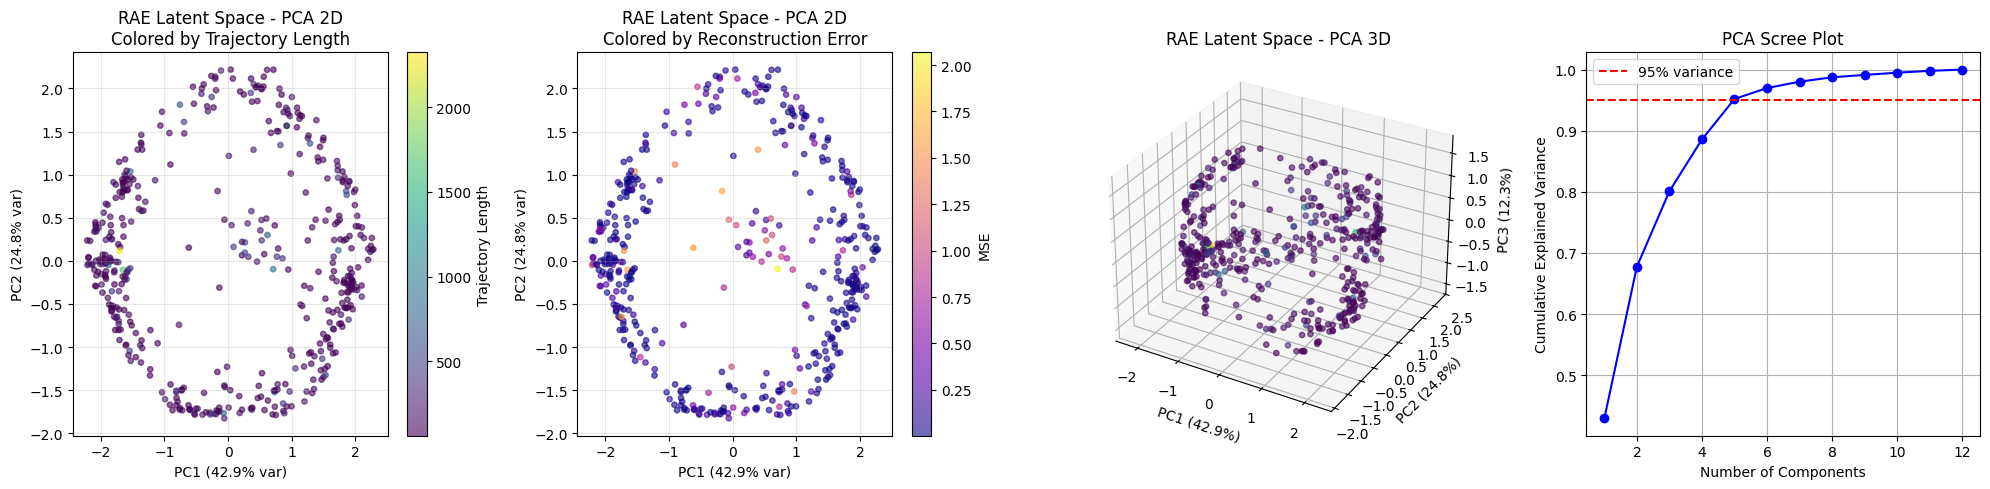

Computing t-SNE... (this may take a minute)


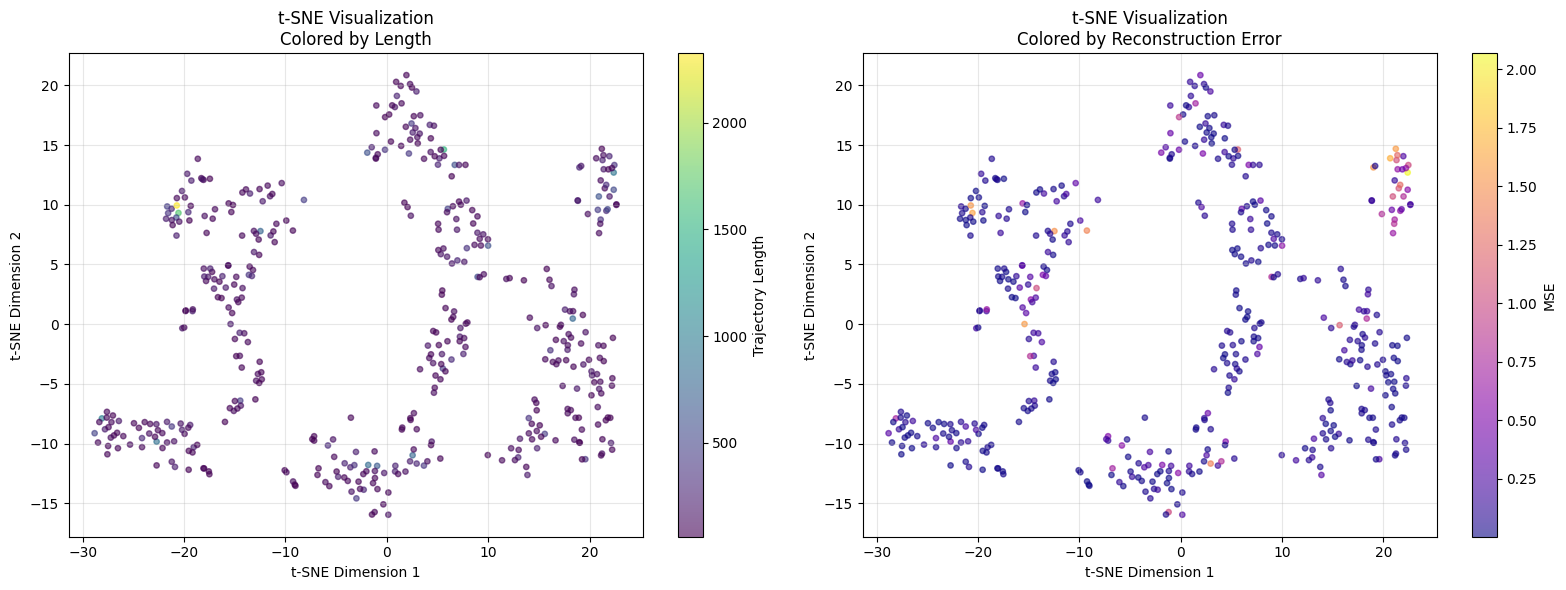

/var/folders/rk/ynqvn_8d77d8956x_nf3jdsc0000gp/T/ipykernel_16023/4070677809.py:153: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([all_latents[:, i] for i in dim_indices], labels=dim_indices)


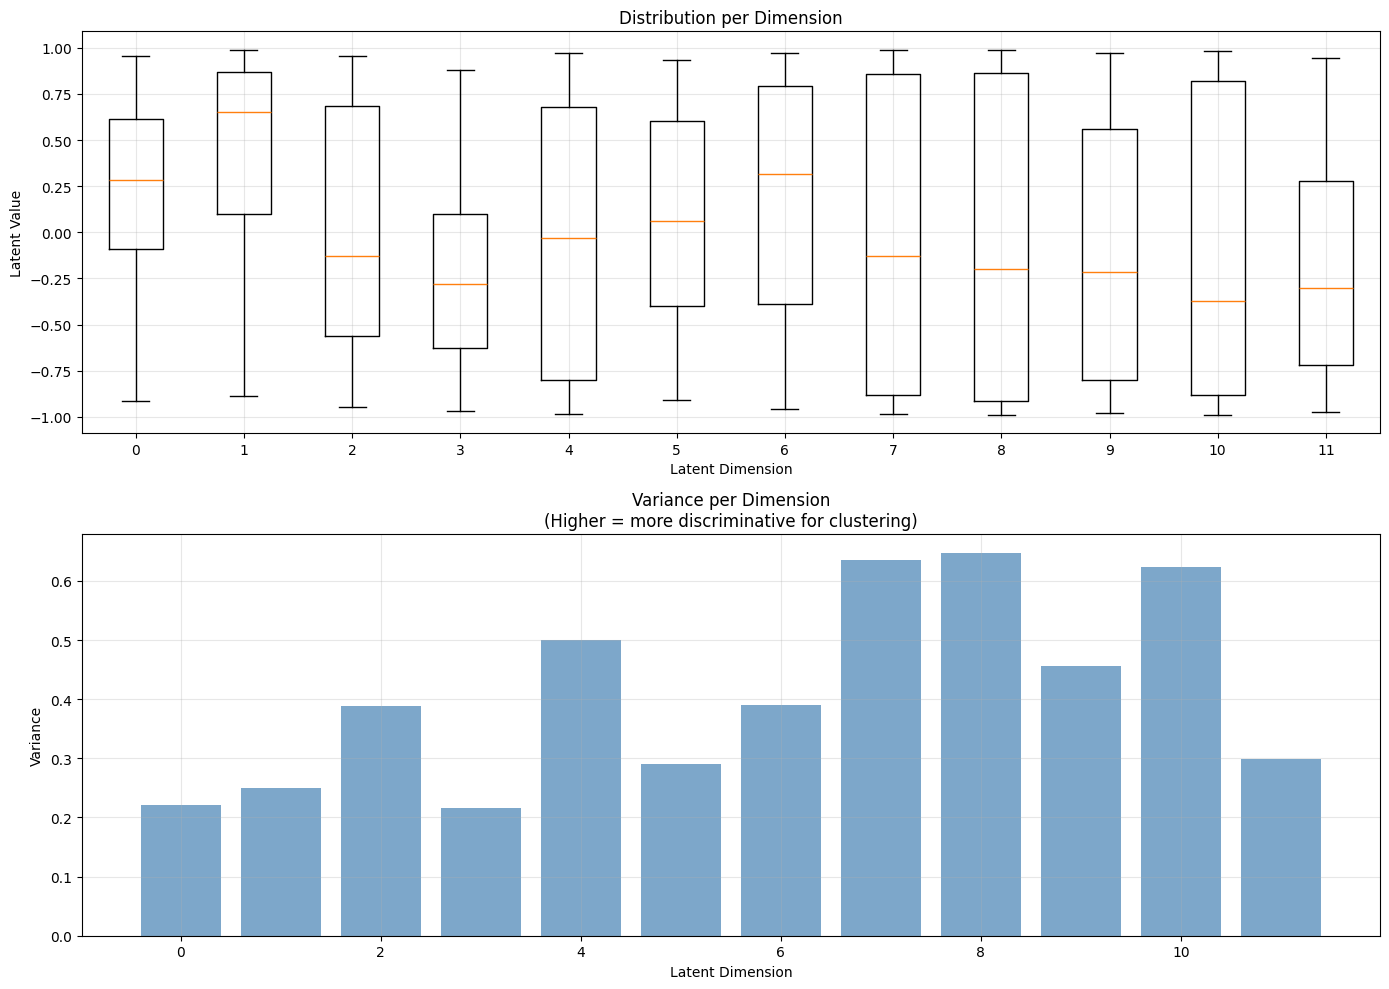

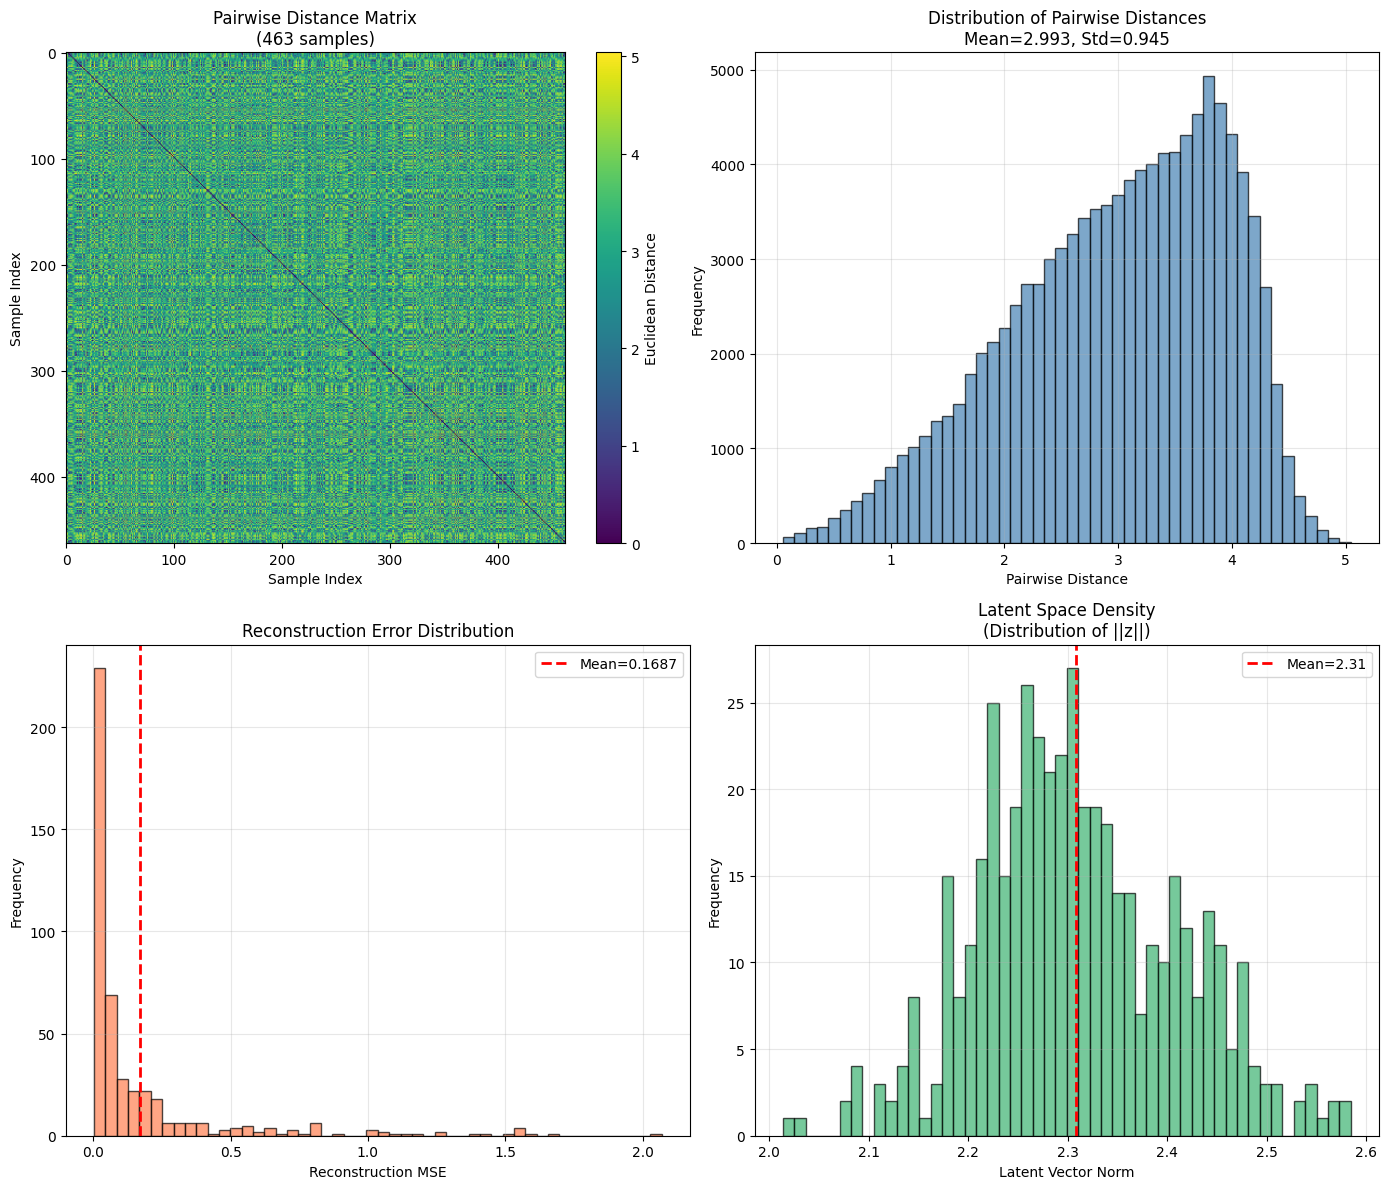

Generating reconstruction examples...


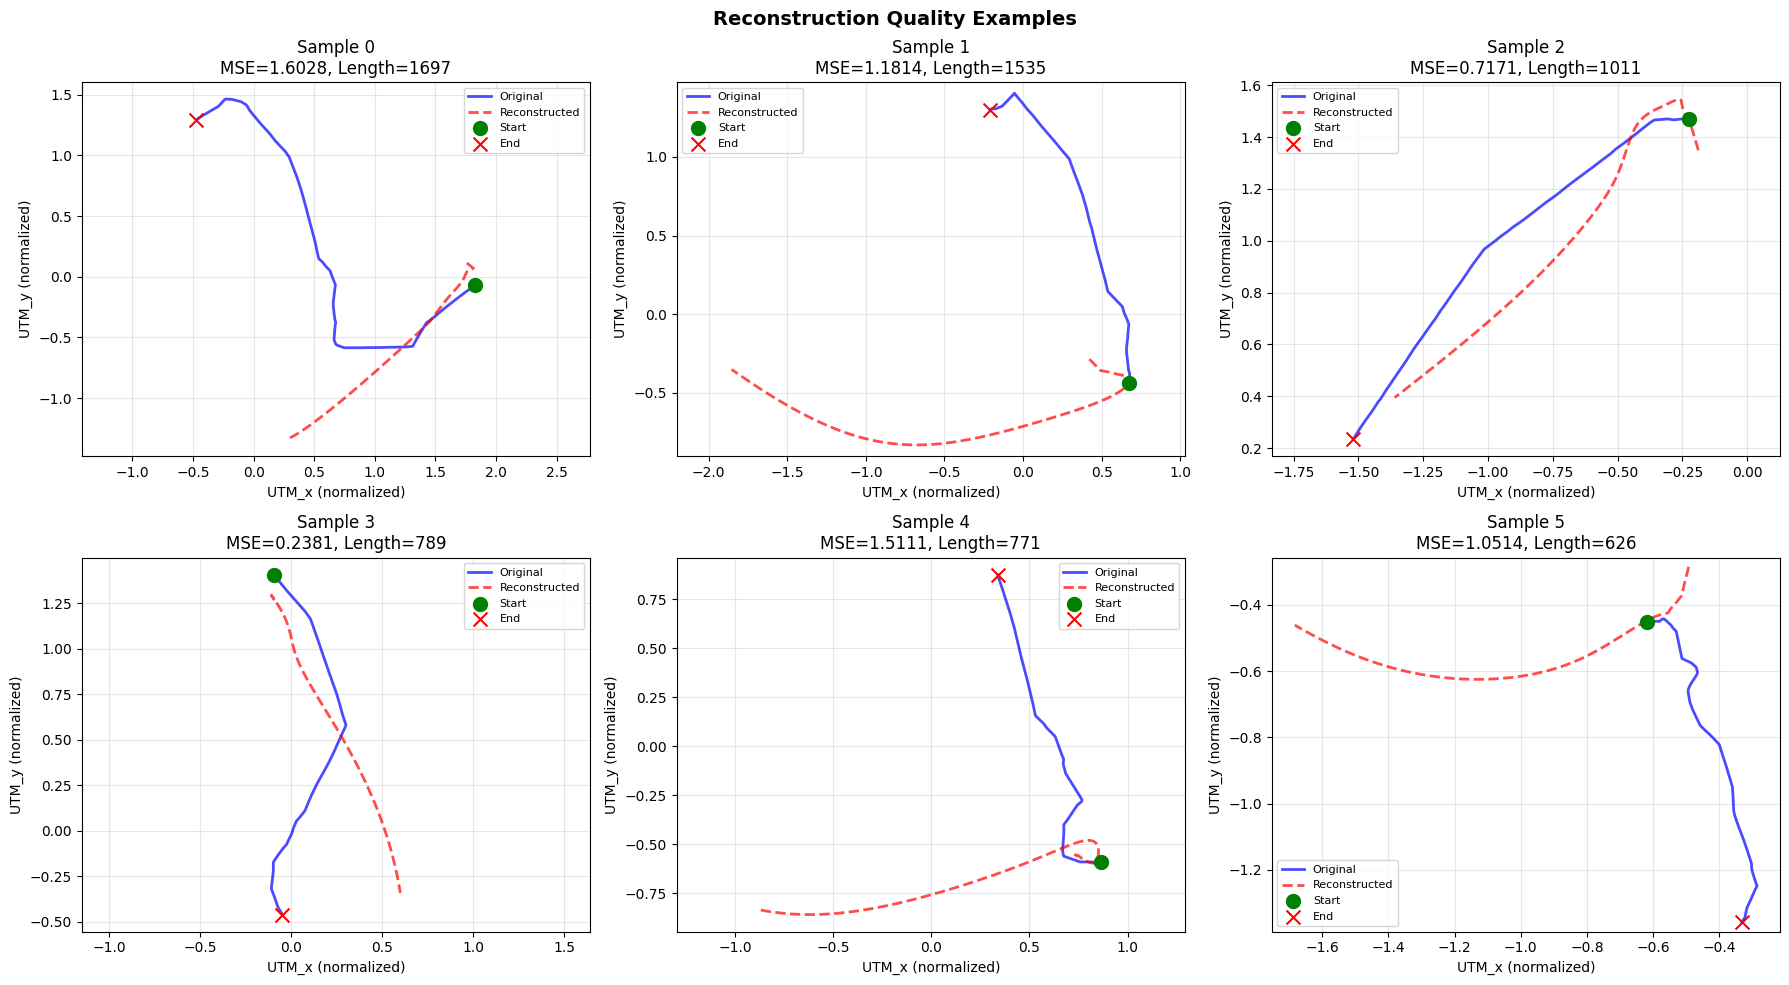

Running K-means clustering preview...


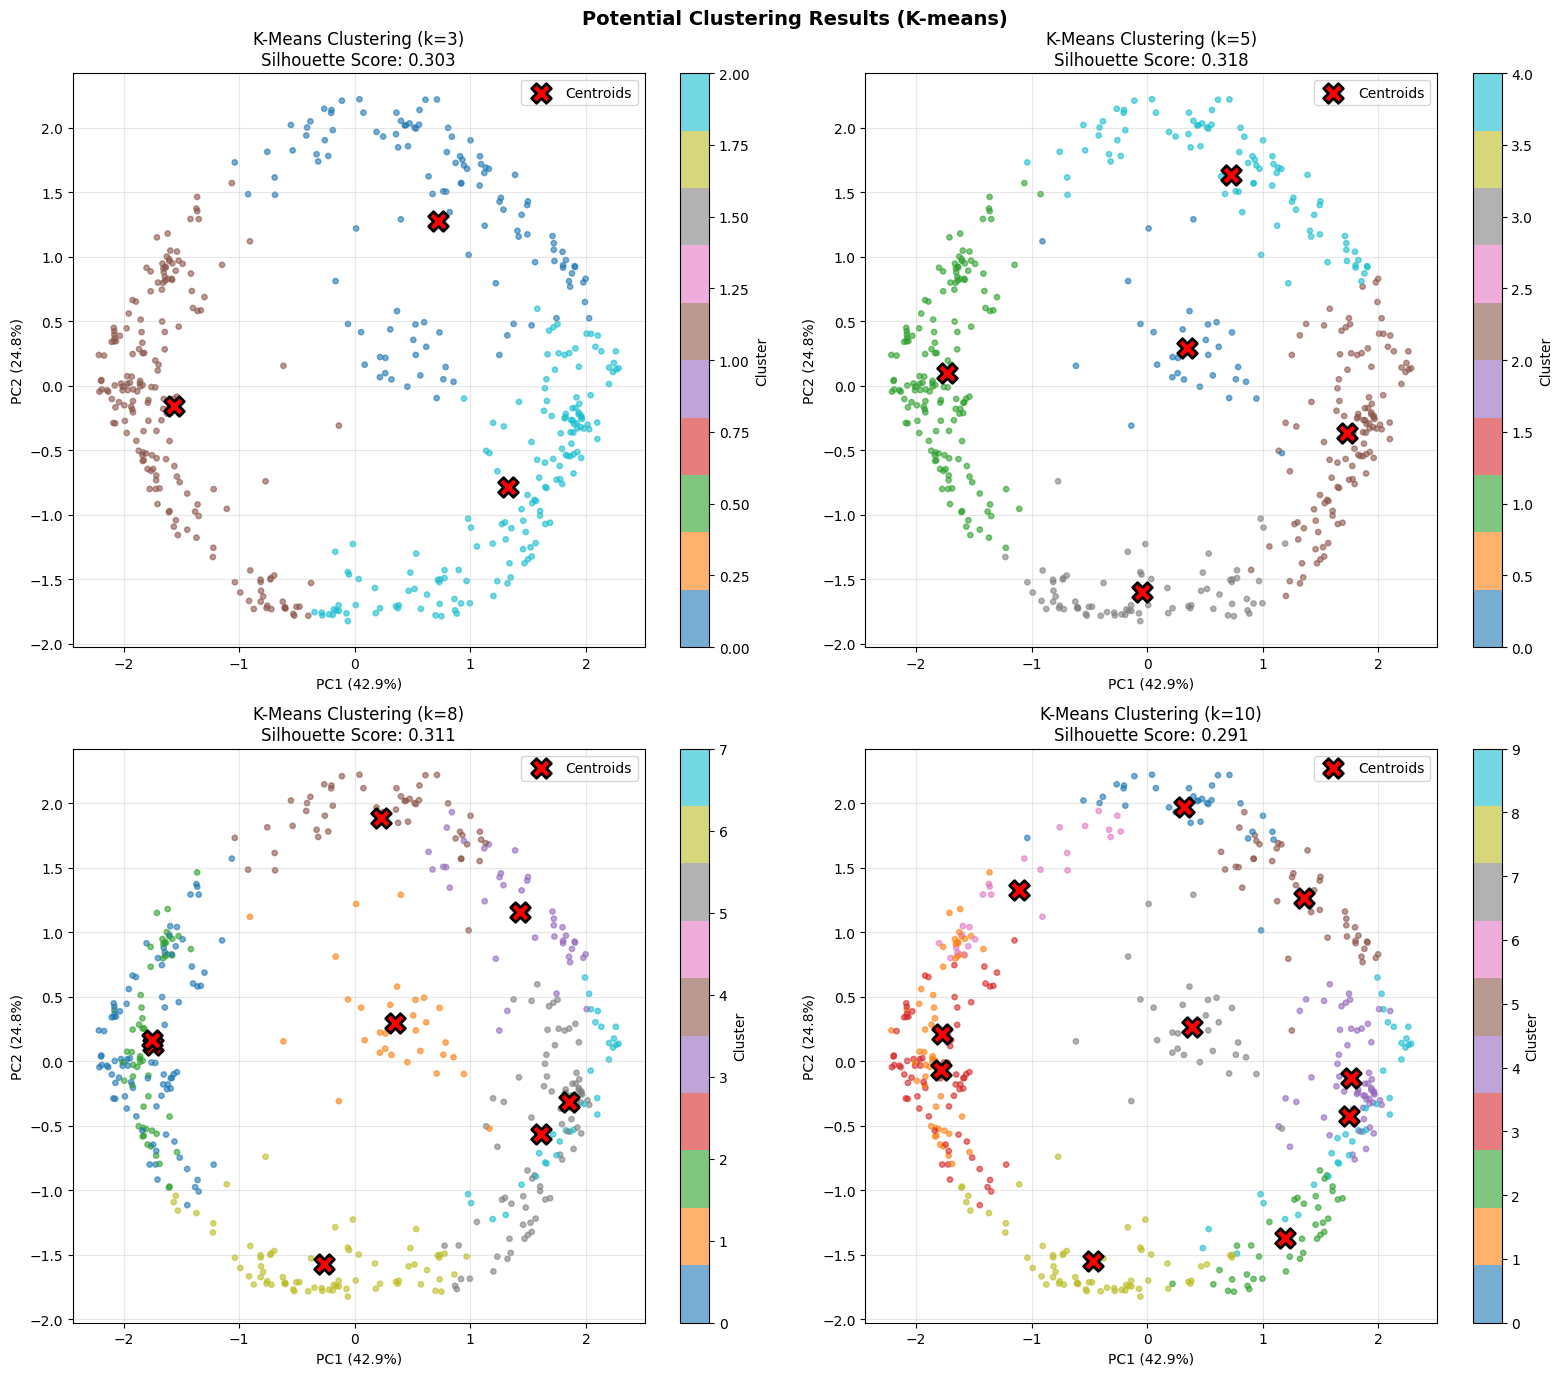


RAE LATENT SPACE ANALYSIS SUMMARY

📊 Dataset Statistics:
  Total samples: 463
  Latent dimensions: 12
  Avg trajectory length: 165.9 ± 195.6

🎯 Latent Space Statistics:
  Mean: 0.0096
  Std:  0.6670
  Norm (mean): 2.3085
  Norm (std):  0.1001

📈 Reconstruction Quality:
  Mean MSE: 0.168746
  Std MSE:  0.307041
  Min MSE:  0.002548
  Max MSE:  2.069652

🔍 Clustering Indicators:
  Mean pairwise distance: 2.9927
  Std pairwise distance:  0.9451
  Variance per dim (mean): 0.4095
  Variance per dim (std):  0.1553
  PCA 95% variance: 5 components
  Active dimensions: 12/12 (100.0%)

🏥 Health Assessment:
  ✅ Overall std > 0.3: Good spread
  ⚠️  High reconstruction error: May need more training
  ✅ Good separation between samples
  ✅ 100% dimensions active: Good capacity usage
  ✅ Good variance: Suitable for clustering

📊 Overall Health Score: 4/5
  🎉 EXCELLENT - Ready for clustering!

✅ All visualizations saved to 'rae_visualizations/'


In [31]:
# Create visualization loader
viz_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad_trajectories
)

# Run RAE visualization
rae_results = visualize_rae_latent_space(
    model=model,  # Your trained RAE model
    data_loader=viz_loader,
    device=device,
    save_dir='rae_visualizations',
    max_samples=5000
)

# Access results
latents = rae_results['latents']
health_score = rae_results['health_score']
pca_transform = rae_results['pca_2d']

In [33]:
encode_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=pad_trajectories
)

In [38]:
len(train_trajectories)

2160

In [34]:
model.eval()
all_train_latents = []
with torch.no_grad():
    for batch, lengths in encode_loader:
        batch = batch.to(device)
        lengths = lengths.to(device)
        z = model.encode(batch, lengths)  # [batch_size, latent_dim]
        all_train_latents.append(z.cpu())

train_latents = torch.cat(all_train_latents, dim=0).numpy()  # shape: [N_trajectories, latent_dim]
print("Encoded train latents:", train_latents.shape)

Encoded train latents: (2160, 12)


In [39]:
import hdbscan

In [ ]:
# Tune HDBSCAN parameters

In [40]:
clusterer = hdbscan.HDBSCAN(
        min_cluster_size=30,   # TODO: Tune
        min_samples=None,      # TODO: Tune
        metric="euclidean",
        cluster_selection_method="eom",
    )

labels = clusterer.fit_predict(train_latents)

/Users/vedabradley/Git/DL-group-63-P29/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vedabradley/Git/DL-group-63-P29/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


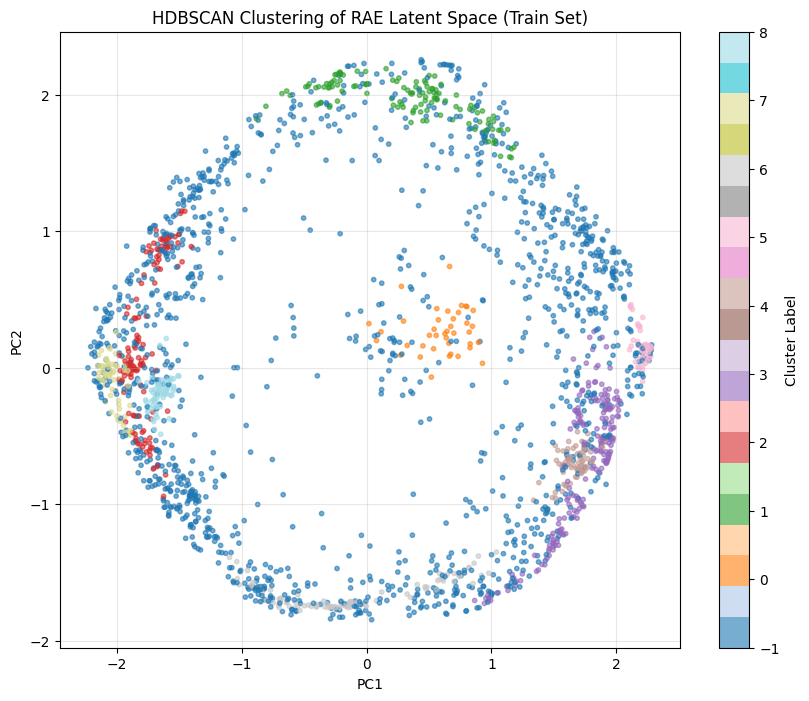

In [ ]:
# Visualise clusters in PCA space
train_latents_pca = pca_transform.transform(train_latents)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    train_latents_pca[:, 0], 
    train_latents_pca[:, 1], 
    c=labels, 
    cmap='tab20', 
    alpha=0.6, 
    s=10
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('HDBSCAN Clustering of RAE Latent Space (Train Set)')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True, alpha=0.3)
plt.show()